<a href="https://colab.research.google.com/github/ProsperChuks/Population-Estimate-and-Projection/blob/main/forecasts/cdr_estimate.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

### Dependecies

In [ ]:
!wget https://github.com/plotly/orca/releases/download/v1.2.1/orca-1.2.1-x86_64.AppImage -O /usr/local/bin/orca
!chmod +x /usr/local/bin/orca
!apt-get install xvfb libgtk2.0-0 libgconf-2-4

In [3]:
!pip install statsmodels --upgrade

     |████████████████████████████████| 9.8 MB 15.0 MB/s 
  Attempting uninstall: statsmodels
    Found existing installation: statsmodels 0.10.2
    Uninstalling statsmodels-0.10.2:
      Successfully uninstalled statsmodels-0.10.2


In [13]:
!pip install scikit-learn --upgrade

     |████████████████████████████████| 23.2 MB 1.5 MB/s 
  Attempting uninstall: scikit-learn
    Found existing installation: scikit-learn 0.22.2.post1
    Uninstalling scikit-learn-0.22.2.post1:
      Successfully uninstalled scikit-learn-0.22.2.post1


In [2]:
import numpy as np
import pandas as pd
import pickle
import plotly.express as px
import matplotlib.pyplot as plt
%matplotlib inline
import statsmodels.api as sm
from pylab import rcParams
from statsmodels.tsa.holtwinters import ExponentialSmoothing
from statsmodels.tsa.ar_model import AutoReg, ar_select_order
from statsmodels.tsa.stattools import acf, pacf
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from fbprophet import Prophet

### Loading Dumped file

In [3]:
world_pop = pickle.load(open('/content/drive/MyDrive/Colab Notebooks/Hamoye Intership/Capstone Project/pickled files/wrld.pkl', 'rb'))
world_growth = pickle.load(open('/content/drive/MyDrive/Colab Notebooks/Hamoye Intership/Capstone Project/pickled files/wgrt.pkl', 'rb'))
cbr = pickle.load(open('/content/drive/MyDrive/Colab Notebooks/Hamoye Intership/Capstone Project/pickled files/cbr.pkl', 'rb'))
cdr = pickle.load(open('/content/drive/MyDrive/Colab Notebooks/Hamoye Intership/Capstone Project/pickled files/cdr.pkl', 'rb'))

### Preprocessing

In [5]:
cdr.CDR = pd.to_numeric(cdr.CDR)
cdr.index = pd.to_datetime(cdr.index, format='%Y')
cdr = cdr.resample('M').interpolate()
cdr

,CDR
MidPeriod,
1958-01-31,17.364085
1958-02-28,17.344565
1958-03-31,17.322953
1958-04-30,17.302039
1958-05-31,17.280427
...,...
2019-09-30,7.593121
2019-10-31,7.595414
2019-11-30,7.597633


#### checking for trend and seasonality

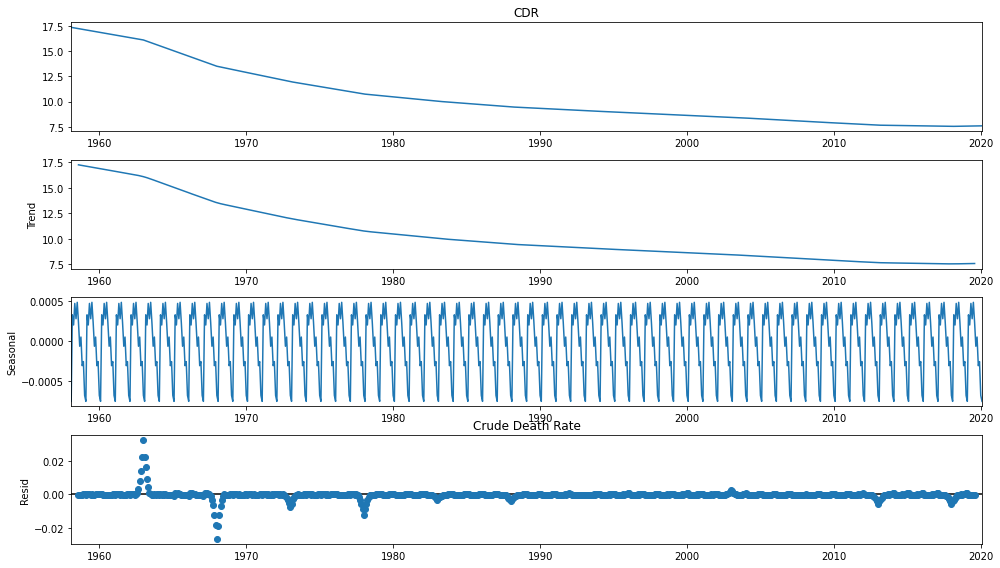

In [6]:
rcParams['figure.figsize'] = 14, 8
cdr.sort_index(inplace=True)
decomp_series = sm.tsa.seasonal_decompose(cdr.CDR, model='addictive')
decomp_series.plot()
plt.title('Crude Death Rate')
plt.show()

### Forecasting the Crude Death Rate

In [7]:
train_df = cdr.iloc[:500]
test_df = cdr.iloc[500:]
test_df

,CDR
MidPeriod,
1999-09-30,8.663670
1999-10-31,8.658204
1999-11-30,8.652913
1999-12-31,8.647447
2000-01-31,8.641980
...,...
2019-09-30,7.593121
2019-10-31,7.595414
2019-11-30,7.597633


#### HoltWinters Exponential Forecast

In [8]:
model = ExponentialSmoothing(train_df['CDR'],
                             trend='add').fit()

predict = model.forecast(245)

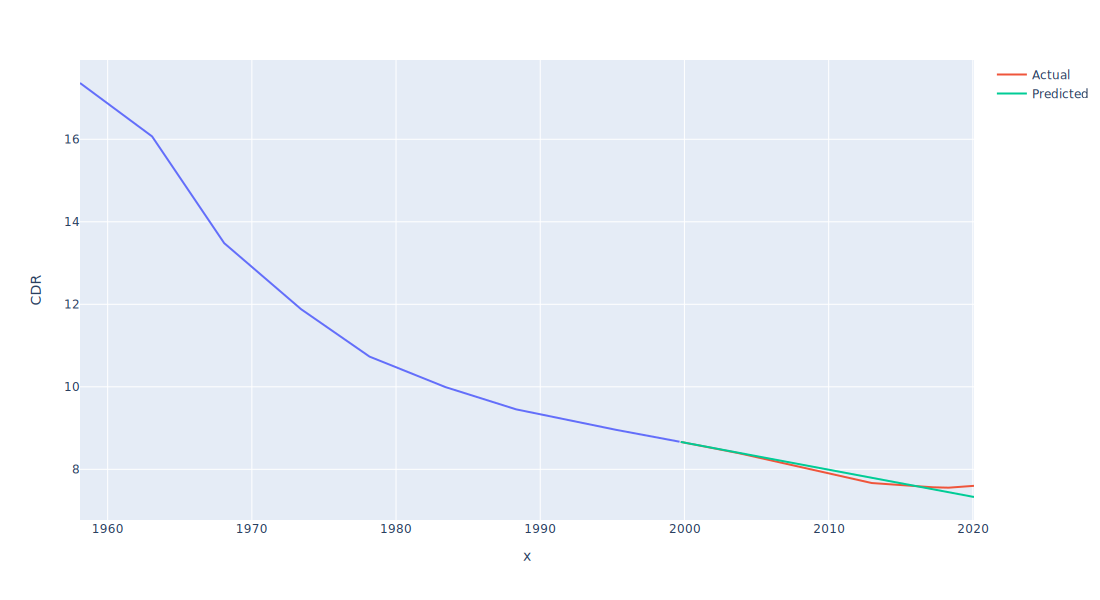

In [9]:
fig = px.line(train_df, train_df.index, 'CDR')
fig.add_scatter(x=test_df.index, y=test_df.CDR, name='Actual')
fig.add_scatter(x=predict.index, y=predict, name='Predicted')
fig.show('svg', height=600, width=1100)

##### metrics

In [10]:
# Mean Absolute Percentage Error
from sklearn.metrics import mean_absolute_percentage_error, mean_squared_error
mape = mean_absolute_percentage_error(test_df, predict)
print('%.2f'%mape, 'MAPE')

# Root Mean Squared Error
rmse = np.sqrt(mean_squared_error(np.array(test_df), np.array(predict)))
print('%.2f'%rmse, 'RMSE')

0.01 MAPE
0.09 RMSE


#### ACF and PACF

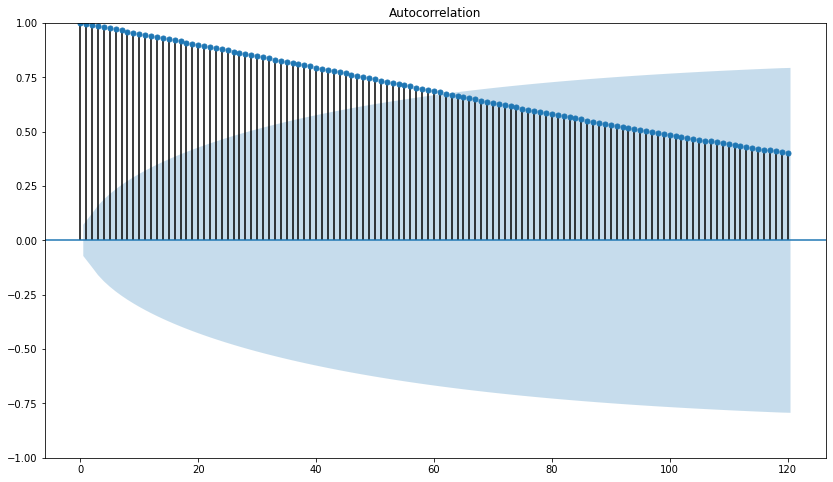

In [11]:
plot_acf(cdr, lags=120)
plt.show()

/usr/local/lib/python3.7/dist-packages/statsmodels/graphics/tsaplots.py:353: FutureWarning:

The default method 'yw' can produce PACF values outside of the [-1,1] interval. After 0.13, the default will change tounadjusted Yule-Walker ('ywm'). You can use this method now by setting method='ywm'.



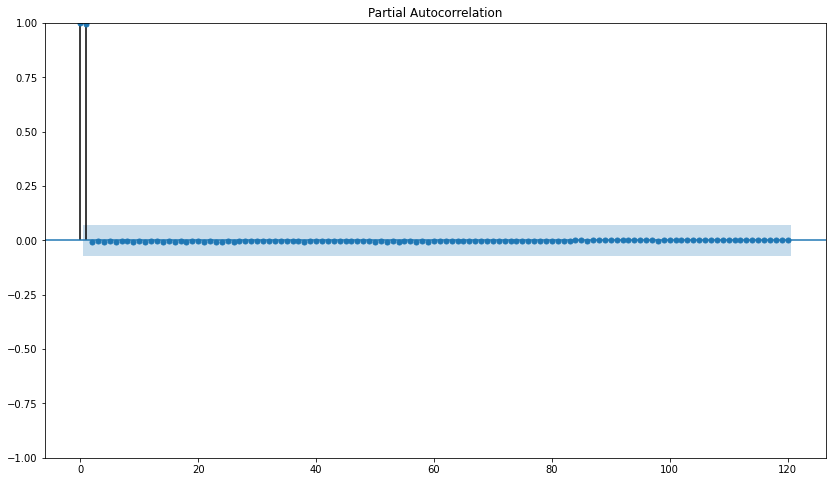

In [12]:
plot_pacf(cdr, lags=120)
plt.show()

#### Auto Regressive Forecast

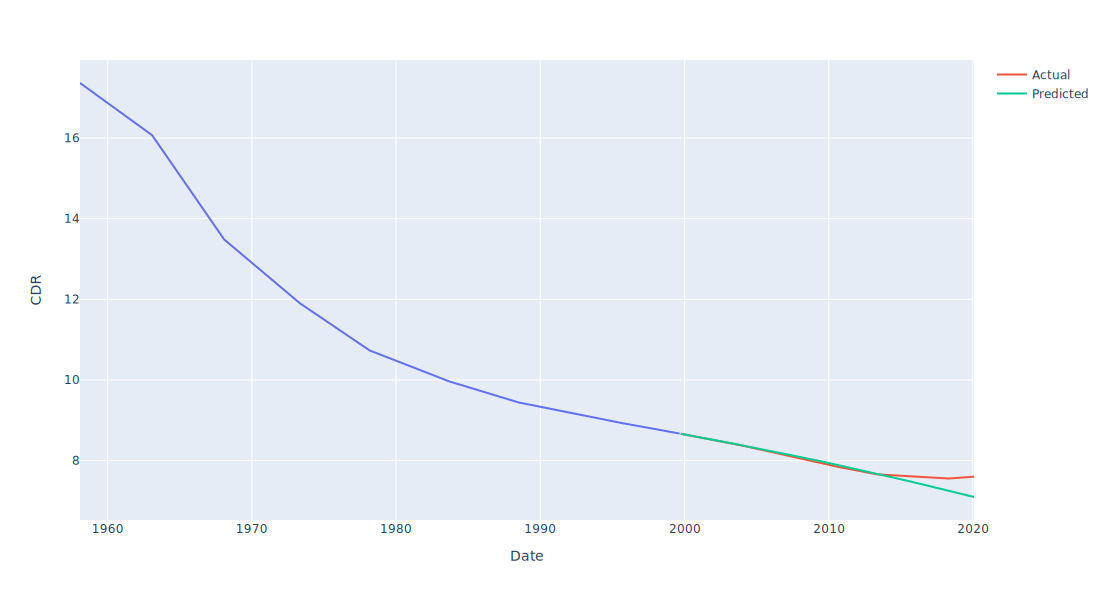

In [13]:
ar_model = AutoReg(train_df['CDR'], 120, trend='ct').fit(cov_type='HC3')
start = len(train_df)
stop = len(train_df) + len(test_df) -1

predict = ar_model.predict(start=start, end=stop, dynamic=True)
fig = px.line(train_df, train_df.index, 'CDR', labels={'x':'Date'})
fig.add_scatter(x=test_df.index, y=test_df.CDR, name='Actual')
fig.add_scatter(x=predict.index, y=predict, name='Predicted')
fig.show('svg', height=600, width=1100)

##### metrics


In [14]:
# Mean Absolute Percentage Error
from sklearn.metrics import mean_absolute_percentage_error, mean_squared_error
mape = mean_absolute_percentage_error(test_df, predict)
print('%.2f'%mape, 'MAPE')

# Root Mean Squared Error
rmse = np.sqrt(mean_squared_error(np.array(test_df), np.array(predict)))
print('%.2f'%rmse, 'RMSE')

0.01 MAPE
0.15 RMSE


#### FBProphet Forecast

In [15]:
cdr.reset_index(inplace=True)
cdr = cdr.rename(columns={'MidPeriod': 'ds', 'CDR': 'y'})
cdr

,ds,y
0,1958-01-31,17.364085
1,1958-02-28,17.344565
2,1958-03-31,17.322953
3,1958-04-30,17.302039
4,1958-05-31,17.280427
...,...,...
740,2019-09-30,7.593121
741,2019-10-31,7.595414
742,2019-11-30,7.597633
743,2019-12-31,7.599926


In [16]:
train_df = cdr.iloc[:500]
test_df = cdr.iloc[500:]
test_df

model = Prophet()
model.fit(train_df)
forecast = model.predict(test_df)

INFO:fbprophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


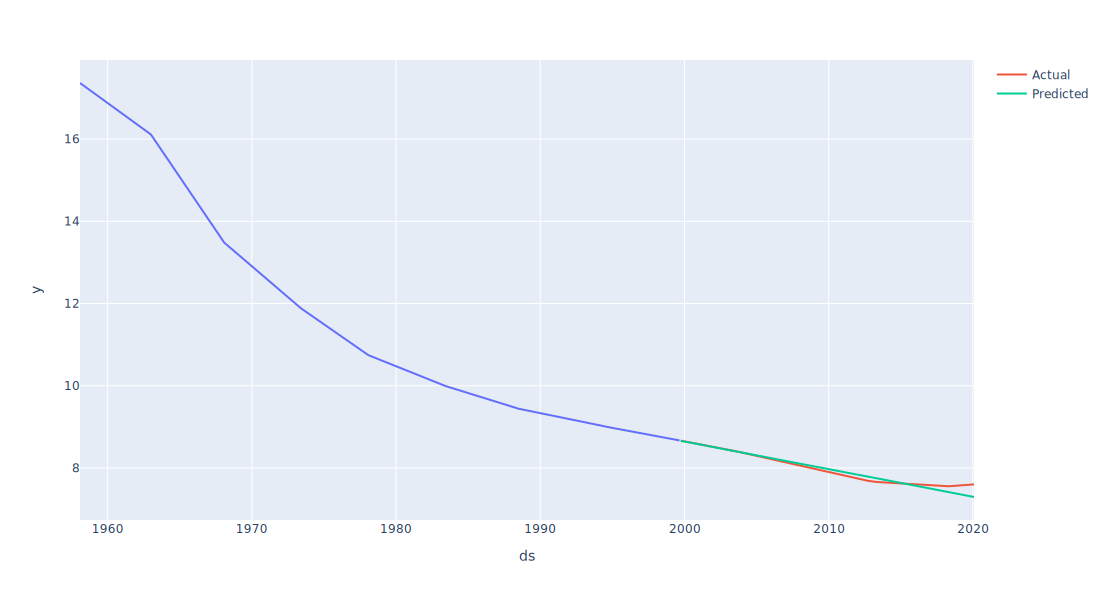

In [17]:
fig = px.line(train_df, train_df.ds, 'y', labels={'x':'Date'})
fig.add_scatter(x=test_df.ds, y=test_df.y, name='Actual')
fig.add_scatter(x=forecast.ds, y=forecast.yhat, name='Predicted')
fig.show('svg', height=600, width=1100)

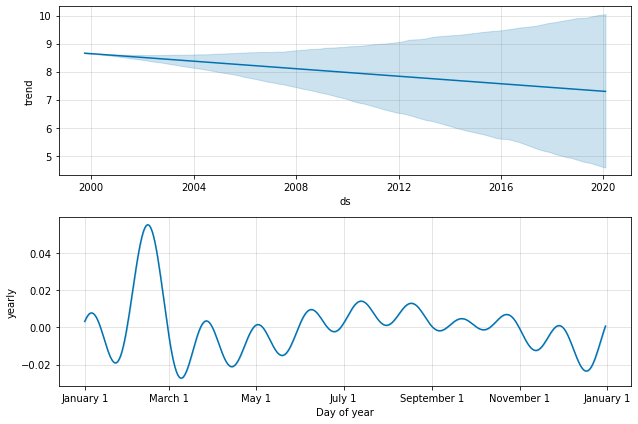

In [18]:
model.plot_components(forecast)
plt.show()

##### metrics

In [19]:
# Mean Absolute Percentage Error
from sklearn.metrics import mean_absolute_percentage_error, mean_squared_error
mape = mean_absolute_percentage_error(test_df['y'], forecast['yhat'])
print('%.2f'%mape, 'MAPE')

# Root Mean Squared Error
rmse = np.sqrt(mean_squared_error(np.array(test_df['y']), np.array(forecast['yhat'])))
print('%.2f'%rmse, 'RMSE')

0.01 MAPE
0.09 RMSE
